In [8]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, UNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss


In [20]:
device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 
device

device(type='cpu')

In [21]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)



model = UNO(3,1, hidden_channels=64, projection_channels=64,uno_out_channels = [32,64,64,64,32], \
            uno_n_modes= [[16,16],[8,8],[8,8],[8,8],[16,16]], uno_scalings=  [[1.0,1.0],[0.5,0.5],[1,1],[2,2],[1,1]],\
            horizontal_skips_map = None, n_layers = 5, domain_padding = 0.2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

Loading test db at resolution 32 with 50 samples and batch-size=32

Our model has 2665921 parameters.


In [3]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [4]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [5]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 UNO(
  (domain_padding): DomainPadding()
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (fno_blocks): ModuleList(
    (0): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleList(
          (0): ComplexDenseTensor(shape=torch.Size([64, 32, 16, 9]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0): Flattened1dConv(
          (conv): Conv1d(64, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
    )
    (1): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleList(
          (0): ComplexDenseTensor(shape=torch.Size([32, 64, 8, 5]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0): Flattened1dConv(
          (conv): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
    )
    (2): FNOBlocks(
      (convs): SpectralConv(
        (weight): ModuleL

In [6]:
trainer = Trainer(model=model,
                   n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [7]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/tmp/ipykernel_42366/3164801846.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


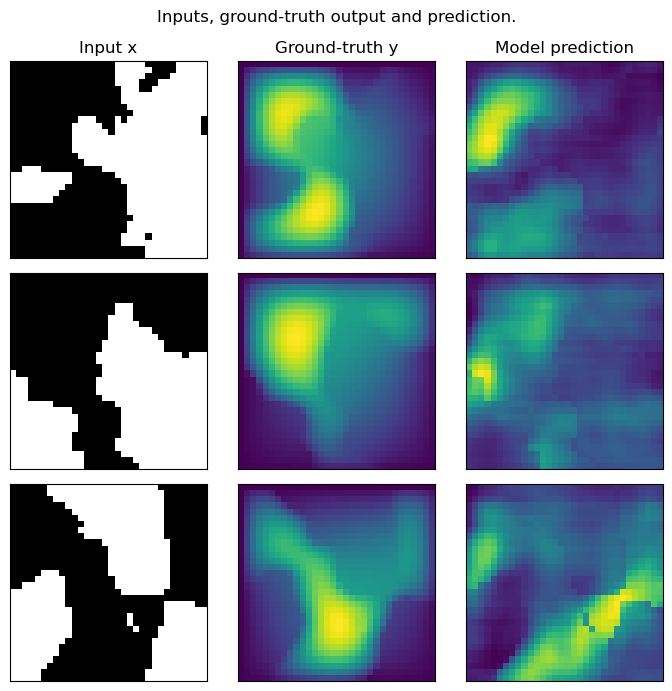

In [8]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).to(device)).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()